In [301]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Flatten, Concatenate, Input, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd

# 데이터 로드 및 전처리

In [118]:

news_data = pd.read_csv('ITchosun_content.csv')

news_data=news_data.rename(columns={"small_category":'category'})
news_data=news_data.dropna(axis=0)
news_data.reset_index(drop=True, inplace=True)
news_data

,link,date,content,tag,title,big_category,category
0,http://it.chosun.com/site/data/html_dir/2020/0...,2020.09.15,"[<div class=""par"">투명 디스플레이 제조업체 레온이 일본 나리타국제공항...","레온,투명디스플레이,초박형,나리타공항,이온몰","레온, 日 나리타공항에 초박형 투명 디스플레이 설치",기업,반도체·디스플레이
1,http://it.chosun.com/site/data/html_dir/2020/0...,2020.09.15,"[<div class=""par"">한글과컴퓨터그룹<span style=""font-si...","한컴위드,한글과컴퓨터,네이버,한컴패스,애니핀,사설인증사업","한컴위드·네이버, '사설인증 사업 협력'을 위한 업무협약 체결",기업,컴퓨팅·IT서비스
2,http://it.chosun.com/site/data/html_dir/2020/0...,2020.09.15,"[<div class=""par"">크라우드 펀딩 플랫폼 와디즈가 건강 먹거리를 선보일...","와디즈,한국야쿠르트,푸드스타트업,스타트업,스타트프레시업,인큐베이팅","와디즈, 한국야쿠르트와 손잡고 푸드 스타트업 육성",기업,중기·벤처
3,http://it.chosun.com/site/data/html_dir/2020/0...,2020.09.15,"[<div class=""par"">""투싼은 현대차 SUV 중에서도 가장 중요한 차라고...","자동차,국산차,현대자동차,투싼,신형투싼,투싼디자인,이상엽","""뒷차 램프 특이하면 현대차일 것""",자동차,일반
4,http://it.chosun.com/site/data/html_dir/2020/0...,2020.09.15,"[<div class=""par"">구글 클라우드 솔루션 전문기업 넷킬러가 구글 지스위...","넷킬러,구글지스위트,넷킬러dlp,문서공유,외부링크공유,문서보안,문서현황파악,기밀유출...","넷킬러, 구글 드라이브 문서 외부 공유 탐지 솔루션 선봬",기업,컴퓨팅·IT서비스
...,...,...,...,...,...,...,...
12415,http://it.chosun.com/site/data/html_dir/2019/0...,2019.03.07,"[<div class=""par"">니콘이미징코리아는 7일 35㎜ 미러리스 Z시리즈를 ...","니콘이미징코리아,35mm,z7,z6,미러리스,가이드북,이벤트,캐시백","니콘, 35mm 미러리스 Z7&Z6; 가이드북 출간",기업,PC·가전·모바일
12416,http://it.chosun.com/site/data/html_dir/2019/0...,2019.03.07,"[<div class=""par"">KB국민은행은 1억5000만달러(약 1680억원) ...","IT조선, itchosun, IT조선, 금융·핀테크","KB국민은행, 1680억원 규모 미국 가스발전소 PF 공동주선",기업,금융·핀테크
12417,http://it.chosun.com/site/data/html_dir/2019/0...,2019.03.07,"[<div class=""par"">한국닌텐도는 오는 4월 12일 ‘닌텐도 라보(Nin...","한국닌텐도,라보,vr,닌텐도스위치",닌텐도 스위치로 가상현실 게임 즐겨요…'라보(Labo) VR 키트' 4월 발매,게임·라이프,게임·인터넷
12418,http://it.chosun.com/site/data/html_dir/2019/0...,2019.03.07,"[<div class=""par"">웹젠은 신작 모바일 다중접속역할수행게임(MMORPG...","마스터탱커,웹젠,모바일게임,중국",모바일 MMORPG ‘마스터탱커’ 3월 11일 정식서비스 확정,게임·라이프,게임·인터넷


In [119]:
news_data['big_category'].unique()

array(['기업', '자동차', '게임·라이프', '기술', '사람', '전체 기사', '뉴스', '칼럼·해설'],
      dtype=object)


================================================

<기술>
- 공통 --> 일반
- 기술 --> 과학·기술 , 보안 , 로봇·드론·VR

=================================================

<게임·라이프>
- 문화/예술 --> 미디어·엔터테인먼트, 게임·인터넷
- 사회 --> 유통·쇼핑, 키덜트·키즈, 일반

=======================================================

<기업>
- 일반, 중기·벤처, 산업일반, 중공업 제거

- 공통 --> 컴퓨팅·IT서비스, 방송·통신, 외신
- 경제 --> 금융·핀테크
- 건강 --> 헬스케어·바이오
- 기술 --> PC·가전·모바일, 반도체·디스플레이


In [120]:
tech=news_data[news_data['big_category'] == '기술'].index ################# 기술
news_data.iloc[tech].category.unique()  # '과학·기술', '일반', '로봇·드론·VR', '보안'

game_life=news_data[news_data['big_category'] == '게임·라이프'].index
news_data.iloc[game_life].category.unique() #'미디어·엔터테인먼트', '게임·인터넷', '유통·쇼핑', '일반', '키덜트·키즈'

company=news_data[news_data['big_category'] == '기업'].index 
news_data.iloc[company].category.unique() #'일반', '컴퓨팅·IT서비스', 'PC·가전·모바일', '금융·핀테크', '중기·벤처', '반도체·디스플레이', '헬스케어·바이오', '외신', '방송·통신', '산업일반', '중공업'


array(['반도체·디스플레이', '컴퓨팅·IT서비스', '중기·벤처', '금융·핀테크', '방송·통신', 'PC·가전·모바일',
       '외신', '헬스케어·바이오', '중공업', '일반', '산업일반'], dtype=object)


카테고리 삭제

In [121]:
news_data['category'].value_counts()

drop1=news_data[news_data['big_category'] == '자동차'].index
news_data=news_data.drop(drop1)
drop2=news_data[news_data['big_category'] == '칼럼·해설'].index
news_data=news_data.drop(drop2)
drop2=news_data[news_data['big_category'] == '사람'].index
news_data=news_data.drop(drop2)
drop2=news_data[news_data['big_category'] == '전체 기사'].index
news_data=news_data.drop(drop2)
drop2=news_data[news_data['big_category'] == '뉴스'].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='일반')].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='중기·벤처')].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='산업일반')].index
news_data=news_data.drop(drop2)
drop2 = news_data[(news_data['big_category']=='기업') & (news_data['category']=='중공업')].index
news_data=news_data.drop(drop2)


news_data.reset_index(drop=True, inplace=True)

팀메이트에 맞는 카테고리로 변환 --> 교육이 없음ㅠㅠ

In [122]:
import numpy as np

news_data['team_category'] = np.nan
news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='과학·기술')].index]='기술'

news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='보안')].index] = '기술'
news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='로봇·드론·VR')].index] = '기술'
news_data['team_category'][news_data[(news_data['big_category']=='기술') & (news_data['category']=='일반')].index]= '공통'

news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='미디어·엔터테인먼트')].index]= '문화/예술'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='게임·인터넷')].index] = '문화/예술'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='유통·쇼핑')].index] = '사회'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='키덜트·키즈')].index] = '사회'
news_data['team_category'][news_data[(news_data['big_category']=='게임·라이프') & (news_data['category']=='일반')].index] = '사회'

news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='컴퓨팅·IT서비스')].index] = '공통'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='방송·통신')].index] = '공통'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='외신')].index]= '공통'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='금융·핀테크')].index] = '경제'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='헬스케어·바이오')].index]= '건강'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='PC·가전·모바일')].index]= '기술'
news_data['team_category'][news_data[(news_data['big_category']=='기업') & (news_data['category']=='반도체·디스플레이')].index] = '기술'



In [123]:
news_data.isna().sum()
news_data['team_category']

0          기술
1          공통
2          공통
3       문화/예술
4          경제
        ...  
9127    문화/예술
9128       기술
9129       경제
9130    문화/예술
9131    문화/예술
Name: team_category, Length: 9132, dtype: object

In [124]:
# 카테고리 정수 인코딩

category_list = pd.factorize(news_data['team_category'])[1]
news_data['category'] = pd.factorize(news_data['team_category'])[0]

news_data['category'].unique()
category_list.nunique()

news_data=news_data[['title','content','tag','category']]

In [125]:
news_data['category'].value_counts() # 6개의 카테고리

1    2814
0    2179
2    1721
3     970
4     962
5     486
Name: category, dtype: int64

# 뉴스 제목, 기사 내용, 태그 내용 전처리

In [126]:
# 뉴스 제목 전처리, 단어 이외의 문자들은 띄어쓰기로 변경
news_data['title'] = news_data['title'].str.replace("[^\w]", " ")

In [127]:
#  기사 내용 전처리, 괄호 단어 뽑기, 괄호 제거, 기호 제거 후 띄어쓰기로 분리 준비

import re
p = re.compile(r'<.+?>') #html 구조 제거
p2 = re.compile(r'\(([^)]+)') # 괄호 뽑기
p3 = re.compile( r'\([^)]*\)') # 괄호 제거

news_data['regex_content'] = ''
news_data['regex_blank'] = ''

for n in range(len(news_data['content'])):
  sub_content= re.sub(p,'',news_data['content'][n]) #html 구조 제거한 기사 문장
  news_data['regex_blank'][n]= p2.findall(news_data['content'][n]) #괄호 단어 뽑은 리스트
  sub_content = re.sub(p3,' ',sub_content) #괄호 제거한 기사 문장
  sub_content = sub_content.replace("[^\w]", " ")
  news_data['regex_content'][n] = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ·∙!』▲\\’‘|\(\)\[\]\<\>`\'…》]', ' ', sub_content)
  

In [128]:
#태그 전처리

news_data['tag_1'] = ''

for i in range(len(news_data['tag'])) :
  news_data['tag_1'][i]= news_data['tag'][i].replace(',',' ')

  # .replace(',',' ')

In [129]:
news_data

,title,content,tag,category,regex_content,regex_blank,tag_1
0,레온 日 나리타공항에 초박형 투명 디스플레이 설치,"[<div class=""par"">투명 디스플레이 제조업체 레온이 일본 나리타국제공항...","레온,투명디스플레이,초박형,나리타공항,이온몰",0,투명 디스플레이 제조업체 레온이 일본 나리타국제공항에 자체 개발한 초박형 투명 디...,[nit],레온 투명디스플레이 초박형 나리타공항 이온몰
1,한컴위드 네이버 사설인증 사업 협력 을 위한 업무협약 체결,"[<div class=""par"">한글과컴퓨터그룹<span style=""font-si...","한컴위드,한글과컴퓨터,네이버,한컴패스,애니핀,사설인증사업",1,한글과컴퓨터그룹 계열사인 한컴위드 가 네이버 와 손잡고 사설인증 시장 선점을...,"[이하 한컴그룹, 경기도 성남시 소재, PKI, AnyPIN, Hancom Pass]",한컴위드 한글과컴퓨터 네이버 한컴패스 애니핀 사설인증사업
2,넷킬러 구글 드라이브 문서 외부 공유 탐지 솔루션 선봬,"[<div class=""par"">구글 클라우드 솔루션 전문기업 넷킬러가 구글 지스위...","넷킬러,구글지스위트,넷킬러dlp,문서공유,외부링크공유,문서보안,문서현황파악,기밀유출...",1,구글 클라우드 솔루션 전문기업 넷킬러가 구글 지스위트 를 도입한 기업이 중요한 자...,"[G Suite, Data Leak Prevention, 열람, 수정 등, 가능할 ...",넷킬러 구글지스위트 넷킬러dlp 문서공유 외부링크공유 문서보안 문서현황파악 기밀유출...
3,게임브리핑 겜밍아웃 하고 청소년 돕는 아이머게이머 챌린지 진행 외 9월 ...,"[<div class=""par"">한국게임산업협회는 게임의 선한 영향력을 알리는 ‘아...","게임브리핑,9월15일,아이머게이머챌린지,한국게임산업협회",2,한국게임산업협회는 게임의 선한 영향력을 알리는 아이머게이머 챌린지 캠페인을 진...,"[I'm a Gamer, 빈칸, D코인, 롤드컵, LPL, LEC, LCK, LCS...",게임브리핑 9월15일 아이머게이머챌린지 한국게임산업협회
4,부산은행 BNK핀테크랩 2기 출범,"[<div class=""par"">BNK부산은행은 부산 해운대구 우동 '센탑'에서 핀...","부산은행,핀테크랩,은행핀테크,bnk,핀테크,핀테크스타트업",3,BNK부산은행은 부산 해운대구 우동 센탑 에서 핀테크 스타트업을 전문 육성하기 ...,"[개인 해외 간편 송금, 온라인 보험 상품 추천, Agora Innovation, ...",부산은행 핀테크랩 은행핀테크 bnk 핀테크 핀테크스타트업
...,...,...,...,...,...,...,...
9127,프린세스 커넥트 리 다이브 사전예약자 70만명 돌파,"[<div class=""par"">카카오게임즈는 사이게임즈에서 개발한 모바일 애니메이...","카카오게임즈,모바일게임,프린세스",2,카카오게임즈는 사이게임즈에서 개발한 모바일 애니메이션 RPG 프린세스 커넥트 ...,"[리:다이브, 리:다이브, 리:다이브, 게임 재화]",카카오게임즈 모바일게임 프린세스
9128,니콘 35mm 미러리스 Z7 Z6 가이드북 출간,"[<div class=""par"">니콘이미징코리아는 7일 35㎜ 미러리스 Z시리즈를 ...","니콘이미징코리아,35mm,z7,z6,미러리스,가이드북,이벤트,캐시백",0,니콘이미징코리아는 7일 35㎜ 미러리스 Z시리즈를 다룬 니콘 Z7 amp;Z6;...,"[20일 발표, Z7 20만원, Z6 15만원]",니콘이미징코리아 35mm z7 z6 미러리스 가이드북 이벤트 캐시백
9129,KB국민은행 1680억원 규모 미국 가스발전소 PF 공동주선,"[<div class=""par"">KB국민은행은 1억5000만달러(약 1680억원) ...","IT조선, itchosun, IT조선, 금융·핀테크",3,KB국민은행은 1억5000만달러 규모의 미국 가스복합화력발전소 프로젝트 파이낸스...,"[약 1680억원, PF, Ares-EIF, Oregon Clean Energy, ...",IT조선 itchosun IT조선 금융·핀테크
9130,닌텐도 스위치로 가상현실 게임 즐겨요 라보 Labo VR 키트 4월 발매,"[<div class=""par"">한국닌텐도는 오는 4월 12일 ‘닌텐도 라보(Nin...","한국닌텐도,라보,vr,닌텐도스위치",2,한국닌텐도는 오는 4월 12일 닌텐도 라보 시리즈 신작 닌텐도 라보 VR ...,"[Nintendo Labo, Nintendo Labo: VR, Toy-Con, Ni...",한국닌텐도 라보 vr 닌텐도스위치


In [130]:
# 메캅 사용 X -> split으로 대체
########################################## ########################################## ########################################## 
# ######################                     MECAB 설치 https://sosomemo.tistory.com/31                     ###################### 
# ########################################## ########################################## ########################################## 

# !apt-get update
# !apt-get install g++ openjdk-8-jdk
# !pip3 install konlpy JPype1-py3
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [131]:
news_data['all']=news_data['title'] +' ' + news_data['tag_1'] + ' ' + news_data['regex_content']
news_data['all']

# 불용어 제거, 토큰화 진행 --> 띄어쓰기 기준으로 문장 잘라 list에 담기
stopwords = ['','▲','밝혔다','있는','의','관련','예정이다','주로','이를','보면','두고','줄','게','역시', '각','볼','다', '등이다','수도','매우','중요한','보였다','혹은','등과','이라는', '관한','itchosun','한다고','이어','후','매일', '여부를','등은','이들은','그동안','했다','할', '◇','시','모든','현재', '1','주요', '이후','설명했다','전','경우','내','하지만','그는', '같은', '총','따라', '가장','것이','대비','관계자는','있도록','최근','기존','한다','것이다','라고','더','중','따르면', '다양한','말했다','이번','것으로','한','이에','다만','하고','또','함께','수','를','을','등','으로','것','약','가','이','즉','은','될','큰','는','로','및','에','그','곧','기자','chosunbiz','며','우리','com','위해','아니라','고','바','와','과','있다','통해','뒤','해','밖에','대한','보다','하는','위한','등을']


X_token = []
for stc in news_data['all']:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_token.append(token)


In [132]:
len(X_token),len(news_data['category'])

(9132, 9132)

In [133]:
news_data['all']

0       레온  日 나리타공항에 초박형 투명 디스플레이 설치  레온 투명디스플레이 초박형 나...
1       한컴위드 네이버   사설인증 사업 협력 을 위한 업무협약 체결  한컴위드 한글과컴퓨...
2       넷킬러  구글 드라이브 문서 외부 공유 탐지 솔루션 선봬  넷킬러 구글지스위트 넷킬...
3        게임브리핑   겜밍아웃 하고 청소년 돕는  아이머게이머 챌린지  진행 외  9월 ...
4       부산은행  BNK핀테크랩  2기 출범  부산은행 핀테크랩 은행핀테크 bnk 핀테크 ...
                              ...                        
9127     프린세스 커넥트  리 다이브  사전예약자 70만명 돌파  카카오게임즈 모바일게임 ...
9128    니콘  35mm 미러리스 Z7 Z6  가이드북 출간  니콘이미징코리아 35mm z7...
9129    KB국민은행  1680억원 규모 미국 가스발전소 PF 공동주선  IT조선  itch...
9130    닌텐도 스위치로 가상현실 게임 즐겨요  라보 Labo  VR 키트  4월 발매  한...
9131    모바일 MMORPG  마스터탱커  3월 11일 정식서비스 확정  마스터탱커 웹젠 모...
Name: all, Length: 9132, dtype: object

# test, trainset / classification fitting

In [134]:
from sklearn.model_selection import train_test_split

# split하면서 shuffle 적용
X_train, X_test, y_train, y_test = train_test_split(X_token, news_data['category'], test_size=0.2,shuffle=True)

# 카테고리 OnehotVector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(len(y_train[0]))
print(len(y_test[0]))

# y_train.nunique(), y_test.nunique()

6
6


In [135]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 헤드라인 정수인코딩
tokenizer = Tokenizer(150000) # 가장 빈도가 높은 150000개의 단어만 선택하도록 함
tokenizer.fit_on_texts(X_train) #vocabulary 만들기
X_train = tokenizer.texts_to_sequences(X_train) # vocabulary랑 매칭해 인덱스로 나타내기, 리스트 변환
X_test = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index

import json
json = json.dumps(word_index)
f3 = open("wordIndex.json", "w")
f3.write(json)
f3.close()

In [136]:
print(len(tokenizer.word_index))

wc = 0
for word, word_count in tokenizer.word_counts.items():
    if word_count <= 2:
        wc += 1

print(wc)

261052
190024


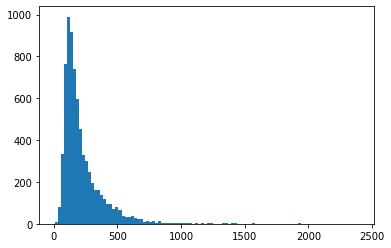

In [137]:
import matplotlib.pyplot as plt # 500단어

len_stc = []
for data in X_train:
    len_stc.append(len(data))

y, x, _ = plt.hist(len_stc, bins=100)
plt.show()

In [138]:
max_len = 500 # 헤드라인 문장 길이를 보고 맞춰주기 - 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [139]:
model = Sequential()
model.add(Embedding(150000, 128))
model.add(LSTM(128))
model.add(Dense(6, activation='softmax')) #출력개수 6개의 카테고리

In [140]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=500, epochs=10)

#batch_size : 한번의 batch마다 주는 데이터 샘플 사이즈/ 한 번에 모든 데이터를 넣을 수가 없음
#iteration 
# epoch : 전체 데이터 셋에 대해 한 번 학습을 완료한 상태

Epoch 1/10
15/15 [==============================] - 39s 3s/step - loss: 1.7299 - acc: 0.3043 - val_loss: 1.6560 - val_acc: 0.3366
Epoch 2/10
15/15 [==============================] - 41s 3s/step - loss: 1.5731 - acc: 0.4338 - val_loss: 1.5126 - val_acc: 0.3831
Epoch 3/10
15/15 [==============================] - 43s 3s/step - loss: 1.2041 - acc: 0.5177 - val_loss: 1.0777 - val_acc: 0.5446
Epoch 4/10
15/15 [==============================] - 53s 4s/step - loss: 0.7876 - acc: 0.7585 - val_loss: 0.8732 - val_acc: 0.6935
Epoch 5/10
15/15 [==============================] - 65s 4s/step - loss: 0.4617 - acc: 0.8613 - val_loss: 0.7998 - val_acc: 0.7126
Epoch 6/10
15/15 [==============================] - 68s 5s/step - loss: 0.2650 - acc: 0.9307 - val_loss: 0.7576 - val_acc: 0.7504
Epoch 7/10
15/15 [==============================] - 72s 5s/step - loss: 0.1356 - acc: 0.9617 - val_loss: 0.6820 - val_acc: 0.7679
Epoch 8/10
15/15 [==============================] - 66s 4s/step - loss: 0.0771 - acc: 0.97

In [141]:
model.save('news_classification_500_10_0.7947.h5')

# AI타임즈 최근 뉴스120개 분류해보기

In [142]:
test_csv=pd.read_csv('AItimes_content.csv')
test_list =pd.read_csv('AItimes_list.csv')

times_data= pd.merge(test_csv, test_list,on='link')
times_data = times_data[['tag','content','title']]

In [143]:
times_data

,tag,content,title
0,"엔비디아,ARM,소프트뱅크,GPU,CPU,반도체",[<p>결국 엔비디아가 ARM을 인수했다. 인수액은 400억달러(약 47조원). 전...,"엔비디아, ARM 인수 '확정'…젠슨 황, ""AI 시대를 위한 결정"""
1,NaN,[<p>광주와 전남지역을 합쳐 하나의 지방자치단체를 만들자는 '광주·전남 행정통합'...,광주·전남 행정 통합 논의 시동 걸었다
2,NaN,"[<p> </p>, <p>1조원의 예산이 투입되는 AI 중심 산업융합 집적단지가 광...",[Monday News] 'AI 중심도시 광주' 이것이 풀어야 할 과제다 ④ 광주 ...
3,"5G,전자파,전자기파,전파,무선통신,이동통신,과기정통부",[<p>국립전파연구원이 전자파에 대한 올바른 정보를 제공한다. 온라인 포럼을 통해 ...,"인체에 유해한 전자파?…국립전파연구원, '팩트체크' 자리 마련"
4,NaN,"[<p>삼성전기가 초소형 파워인덕터를 개발했다. </p>, <p>파워인덕터는 반도체...","삼성전기, 초소형 파워인덕터 개발…엣지 AI 소형화 가속"
...,...,...,...
115,"국립전파연구원,국제전기통신연합,ITU,ITU-T,SG17,양자암호통신,정보보호,국제...",[<p>국제표준기구가 국내 연구진 주도로 제안한 정보보호 분야 표준안 8건을 국제 ...,국내 주도 ICT 보안 표준안 8건 '국제 표준' 채택
116,NaN,[<p>4족 보행 로봇 ‘스폿(Spot)’이 코로나19 최전방에서 고생하는 의료진에...,"로봇견 ‘스폿’, 코로나19 최전방서 의료진 도와 활약할까"
117,"산업통상자원부,인공지능반도체,AI반도체,자율주행차,사물인터넷,IoT,바이오,로봇,미세공정",[<p>정부가 인공지능(AI) 반도체 상용화를 목표로 관련 기술 개발에 착수한다. ...,"산업부, AI 반도체 상용화 위한 기술 개발 추진… 미래차ㆍIoT 등에 적용한다"
118,"한국인공지능학회,인공지능,AI,인공지능대학원,AI대학원,바이오의료,신경과학,컴퓨터비전",[<p>한국인공지능학회(학회장 유창동)는 인공지능(AI) 연구자의 학술 교류 및 최...,"한국인공지능학회, '2020년 하계학술대회' 열어 AI 연구 조망"


In [144]:
# 뉴스 제목 전처리, 단어 이외의 문자들은 띄어쓰기로 변경
times_data['title'] = times_data['title'].str.replace("[^\w]", " ")

# 기사 내용 전처리, 괄호 단어 뽑기, 괄호 제거 후 띄어쓰기
import re
p = re.compile(r'<.+?>') #html 구조 제거
p2 = re.compile(r'\(([^)]+)') # 괄호 뽑기
p3 = re.compile( r'\([^)]*\)') # 괄호 제거

times_data['regex_content'] = ''
times_data['regex_blank'] = ''

for n in range(len(times_data['content'])):
  sub_content= re.sub(p,'',times_data['content'][n]) #html 구조 제거한 기사 문장
  times_data['regex_blank'][n]= p2.findall(times_data['content'][n]) #괄호 단어 뽑은 리스트
  sub_content = re.sub(p3,' ',sub_content) #괄호 제거한 기사 문장
  sub_content = sub_content.replace("[^\w]", " ")
  times_data['regex_content'][n] = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ·∙!』▲\\’‘|\(\)\[\]\<\>`\'…》]', ' ', sub_content)
  
times_data['regex_content']

# 태그 내용 전처리

times_data['tag_1'] = ''
for i in range(len(times_data['tag'])) :
  if times_data['tag'].isnull()[i]: times_data['tag_1'][i] = ""
  else : times_data['tag_1'][i]= times_data['tag'][i].replace(',',' ')

  
times_data['all']=times_data['title'] +' ' + times_data['tag_1'] + ' ' + times_data['regex_content']
times_data['all']

0      엔비디아  ARM 인수  확정  젠슨 황   AI 시대를 위한 결정  엔비디아 AR...
1      광주 전남 행정 통합 논의 시동 걸었다   광주와 전남지역을 합쳐 하나의 지방자치단...
2       Monday News   AI 중심도시 광주  이것이 풀어야 할 과제다 ④ 광주 ...
3      인체에 유해한 전자파  국립전파연구원   팩트체크  자리 마련 5G 전자파 전자기파...
4      삼성전기  초소형 파워인덕터 개발 엣지 AI 소형화 가속   삼성전기가 초소형 파워...
                             ...                        
115    국내 주도 ICT 보안 표준안 8건  국제 표준  채택 국립전파연구원 국제전기통신연...
116    로봇견  스폿   코로나19 최전방서 의료진 도와 활약할까   4족 보행 로봇  스...
117    산업부  AI 반도체 상용화 위한 기술 개발 추진  미래차ㆍIoT 등에 적용한다 산...
118    한국인공지능학회   2020년 하계학술대회  열어 AI 연구 조망 한국인공지능학회 ...
119     턱스크 잡는다    LG U    AIㆍ5G 방역로봇  개발   마스크 착용 여부...
Name: all, Length: 120, dtype: object

In [145]:
# 불용어 제거, 토큰화 진행 --> 띄어쓰기 기준으로 문장 잘라 list에 담기

stopwords = ['','▲','밝혔다','있는','의','관련','예정이다','주로','이를','보면','두고','줄','게','역시', '각','볼','다', '등이다','수도','매우','중요한','보였다','혹은','등과','이라는', '관한','itchosun','한다고','이어','후','매일', '여부를','등은','이들은','그동안','했다','할', '◇','시','모든','현재', '1','주요', '이후','설명했다','전','경우','내','하지만','그는', '같은', '총','따라', '가장','것이','대비','관계자는','있도록','최근','기존','한다','것이다','라고','더','중','따르면', '다양한','말했다','이번','것으로','한','이에','다만','하고','또','함께','수','를','을','등','으로','것','약','가','이','즉','은','될','큰','는','로','및','에','그','곧','기자','chosunbiz','며','우리','com','위해','아니라','고','바','와','과','있다','통해','뒤','해','밖에','대한','보다','하는','위한','등을']

X_token = []
for stc in times_data['all']:
    token = []
    words = stc.split()
    for word in words:
        if word not in stopwords:
            token.append(word)
    X_token.append(token)

In [158]:
# token_stc =m.nouns(sentence)
from tensorflow.keras.models import load_model
model = load_model('news_classification_500_10_0.7947.h5')
empty = []

for token_stc in X_token :
  encode_stc = tokenizer.texts_to_sequences([token_stc])
  pad_stc = pad_sequences(encode_stc, maxlen=500)
  score = model.predict(pad_stc)
  result_category = category_list[score.argmax()]
  result_prob= score[0, score.argmax()] # 확률값 반환
  empty.append([result_category, result_prob])

In [159]:
result=pd.DataFrame(empty,columns=['category','prob'])
resultttt=pd.concat([times_data,result],axis=1)

resultttt[['title','category','prob']]

,title,category,prob
0,엔비디아 ARM 인수 확정 젠슨 황 AI 시대를 위한 결정,공통,0.991313
1,광주 전남 행정 통합 논의 시동 걸었다,공통,0.334632
2,Monday News AI 중심도시 광주 이것이 풀어야 할 과제다 ④ 광주 ...,공통,0.874326
3,인체에 유해한 전자파 국립전파연구원 팩트체크 자리 마련,공통,0.982499
4,삼성전기 초소형 파워인덕터 개발 엣지 AI 소형화 가속,기술,0.989388
...,...,...,...
115,국내 주도 ICT 보안 표준안 8건 국제 표준 채택,기술,0.810954
116,로봇견 스폿 코로나19 최전방서 의료진 도와 활약할까,공통,0.747474
117,산업부 AI 반도체 상용화 위한 기술 개발 추진 미래차ㆍIoT 등에 적용한다,기술,0.716872
118,한국인공지능학회 2020년 하계학술대회 열어 AI 연구 조망,공통,0.705879


In [160]:
resultttt.category.value_counts()

공통       72
기술       33
문화/예술     8
경제        5
사회        2
Name: category, dtype: int64

In [161]:
resultttt[resultttt.category == '문화/예술'].sort_values(['prob'],ascending=False)

,tag,content,title,regex_content,regex_blank,tag_1,all,category,prob
41,"네이버,연세대학교,MOU,협약식,상호협약,SW,HW,온라인협약,교육과정공동개발",[<p>네이버와 연세대가 AI 교육과 산학 협력 프로젝트를 위해 힘을 모은다.</p...,네이버 연세대학교 AI 인재 발굴 위한 협력 제휴,네이버와 연세대가 AI 교육과 산학 협력 프로젝트를 위해 힘을 모은다 네이버 ...,"[대표이사 한성숙, 총장 서승환, HW, SW]",네이버 연세대학교 MOU 협약식 상호협약 SW HW 온라인협약 교육과정공동개발,네이버 연세대학교 AI 인재 발굴 위한 협력 제휴 네이버 연세대학교 MOU 협약식...,문화/예술,0.926351
99,NaN,[<p>미래 국내 게임 산업을 이끌 스타트업 기업을 발굴하는 지역행사가 성공적으로 ...,전남에서 게임 창업하자 스타트업 지원 행사 눈길,미래 국내 게임 산업을 이끌 스타트업 기업을 발굴하는 지역행사가 성공적으로 개최돼...,"[AI, AR, VR]",,전남에서 게임 창업하자 스타트업 지원 행사 눈길 미래 국내 게임 산업을 ...,문화/예술,0.903985
46,NaN,[<p>국내 가상현실(VR) 콘텐츠 진화는 어느 단계까지 와 있을까? 전남 나주혁신...,VR 콘텐츠 진화 BCWW에서 확인한다,국내 가상현실 콘텐츠 진화는 어느 단계까지 와 있을까 전남 나주혁신도시에 위치...,"[VR, BCWW, AI]",,VR 콘텐츠 진화 BCWW에서 확인한다 국내 가상현실 콘텐츠 진화는 어느 단계...,문화/예술,0.902828
32,NaN,[<p>데이터 과학자들이 한데 모여 앨범자켓만으로 장르를 구별해내는 AI를 개발했다...,앨범자켓만으로 장르 구분하는 AI 나온다,데이터 과학자들이 한데 모여 앨범자켓만으로 장르를 구별해내는 AI를 개발했다 ...,"[주황색 표시, 약 7000억원]",,앨범자켓만으로 장르 구분하는 AI 나온다 데이터 과학자들이 한데 모여 앨범자켓만...,문화/예술,0.629920
82,"카카오,경기도청,데이터센터,한양대,네트워크,서버,스토리지,AI,클라우드","[<p>카카오(대표 여민수, 조수용)가 4000억원을 투입해 경기도 안산시 소재 한...",카카오 한양대 에리카 캠퍼스에 6EB 규모 데이터센터 건설한다,카카오 가 4000억원을 투입해 경기도 안산시 소재 한양대 에리카 캠퍼스에 6EB...,"[대표 여민수, 조수용, 엑사바이트, MOU, 엑사바이트]",카카오 경기도청 데이터센터 한양대 네트워크 서버 스토리지 AI 클라우드,카카오 한양대 에리카 캠퍼스에 6EB 규모 데이터센터 건설한다 카카오 경기도청 데...,문화/예술,0.612981
113,NaN,[<p>미 국방부(펜타곤)가 2일(현지시간) 구글과 협업해 퇴역 참전용사가 겪는 특...,펜타곤 구글 암 투병 퇴역 군인 위해 AI 활용,미 국방부 가 2일 구글과 협업해 퇴역 참전용사가 겪는 특정 암을 연구하고 식별...,"[펜타곤, 현지시간, DHA, DARPA, 다르파]",,펜타곤 구글 암 투병 퇴역 군인 위해 AI 활용 미 국방부 가 2일 구글과 ...,문화/예술,0.470480
38,NaN,[<p>광주광역시가 인공지능(AI)과 문화기술(CT)를 활용해 지역 문화재를 보전한...,광주 지역 무형문화재 AI로 보전한다,광주광역시가 인공지능 과 문화기술 를 활용해 지역 문화재를 보전한다 광주시는 광...,"[AI, CT, 국비 25, 시비 25, AI, CT]",,광주 지역 무형문화재 AI로 보전한다 광주광역시가 인공지능 과 문화기술 를 활...,문화/예술,0.469742
103,NaN,[<p>지난 8월 18일부터 AI타임스가 시작한 특집 기획 [한국의 인공지능대학원]...,특집 한국의 8대 인공지능대학원 총 집합,지난 8월 18일부터 AI타임스가 시작한 특집 기획 한국의 인공지능대학원 이 9...,"[GIST, AI, 입학금 포함]",,특집 한국의 8대 인공지능대학원 총 집합 지난 8월 18일부터 AI타임스가 ...,문화/예술,0.377623
